<a href="https://colab.research.google.com/github/sathu0622/25-26J-438-AI-Powered-LMS-for-Visually-Impaired-Students/blob/AI-Powered-System-for-Voice-Based-Resource-Type-Summarization-of-Historical-Content-for-VIS/CNN_Resource_Type_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import os, glob


In [3]:
DATASET_DIR = "/content/drive/MyDrive/Image_JPG"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 40
SEED = 42


In [4]:
all_images = glob.glob(os.path.join(DATASET_DIR, "*", "*.jpg"))

class_names = sorted([
    d for d in os.listdir(DATASET_DIR)
    if os.path.isdir(os.path.join(DATASET_DIR, d))
])

label2idx = {name: i for i, name in enumerate(class_names)}
labels = [label2idx[os.path.basename(os.path.dirname(p))] for p in all_images]


In [5]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_images,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=SEED
)


In [6]:
def preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label


In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [8]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.1382113821138211), 1: np.float64(0.7415254237288136), 2: np.float64(1.2939001848428835)}


In [9]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),
])


In [10]:
model = models.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),   # ✅ Explicit input

    data_augmentation,

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(len(class_names), activation='softmax')
])


In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 457,156 (1.74 MB)

 Trainable params: 456,196 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [12]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6
)


In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 495s 4s/step - accuracy: 0.7267 - loss: 0.6846 - val_accuracy: 0.3042 - val_loss: 2.1092 - learning_rate: 0.0010
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 59s 593ms/step - accuracy: 0.8411 - loss: 0.4164 - val_accuracy: 0.3232 - val_loss: 3.8821 - learning_rate: 0.0010
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 561ms/step - accuracy: 0.8678 - loss: 0.3672 - val_accuracy: 0.4468 - val_loss: 2.9355 - learning_rate: 0.0010
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 565ms/step - accuracy: 0.8848 - loss: 0.3173 - val_accuracy: 0.4144 - val_loss: 3.3945 - learning_rate: 0.0010
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 561ms/step - accuracy: 0.9120 - loss: 0.2704 - val_accuracy: 0.3897 - val_loss: 3.2739 - learning_rate: 3.0000e-04
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 561ms/step - accuracy: 0.9394 - loss: 0.1831 - val_accuracy: 0.5951 - val_loss: 1.6999 - learning_rate: 3.0000e-04
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 540ms/step - accuracy: 0.9220 - lo

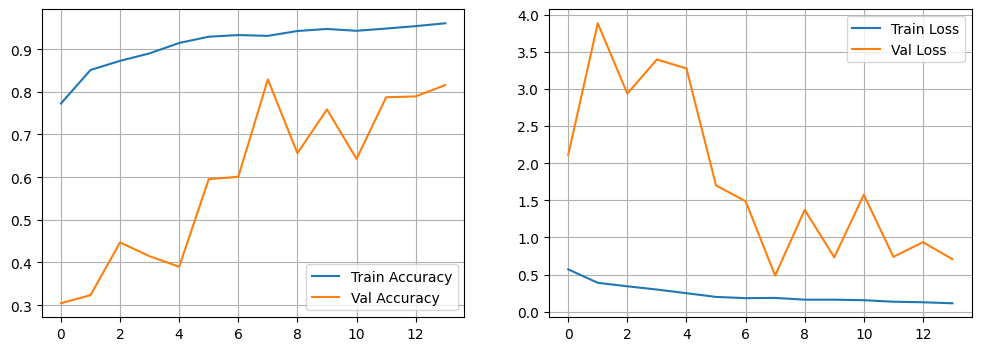

In [14]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.grid()

plt.show()


In [15]:
model_path = "/content/drive/MyDrive/Image/cnn_book_magazine_newspaper.keras"
model.save(model_path)

print("✅ Model saved at:", model_path)


✅ Model saved at: /content/drive/MyDrive/Image/cnn_book_magazine_newspaper.keras
